In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!rm kaggle.json

In [ ]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
100% 1.21G/1.21G [01:04<00:00, 20.8MB/s]
100% 1.21G/1.21G [01:04<00:00, 20.1MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/gtzan-dataset-music-genre-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# **Exploratory Data Analysis (EDA) for GTZAN Dataset**

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from librosa import feature
import IPython.display as ipd  # To play sound in the notebook
import json
from matplotlib.pyplot import specgram
import glob
from tqdm import tqdm
import pickle
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, utils, models
from torch.autograd import Variable
import torch.optim as optim

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


In [ ]:
MUSIC = '/content/Data/genres_original'
classes = os.listdir(MUSIC)
print("Classes:", classes)

Classes: ['rock', 'classical', 'country', 'pop', 'blues', 'reggae', 'hiphop', 'disco', 'jazz', 'metal']


DataFrame shape: (999, 2)
                                           file_path   genre
0  /content/Data/genres_original/hiphop/hiphop.00...  hiphop
1  /content/Data/genres_original/hiphop/hiphop.00...  hiphop
2  /content/Data/genres_original/hiphop/hiphop.00...  hiphop
3  /content/Data/genres_original/hiphop/hiphop.00...  hiphop
4  /content/Data/genres_original/hiphop/hiphop.00...  hiphop


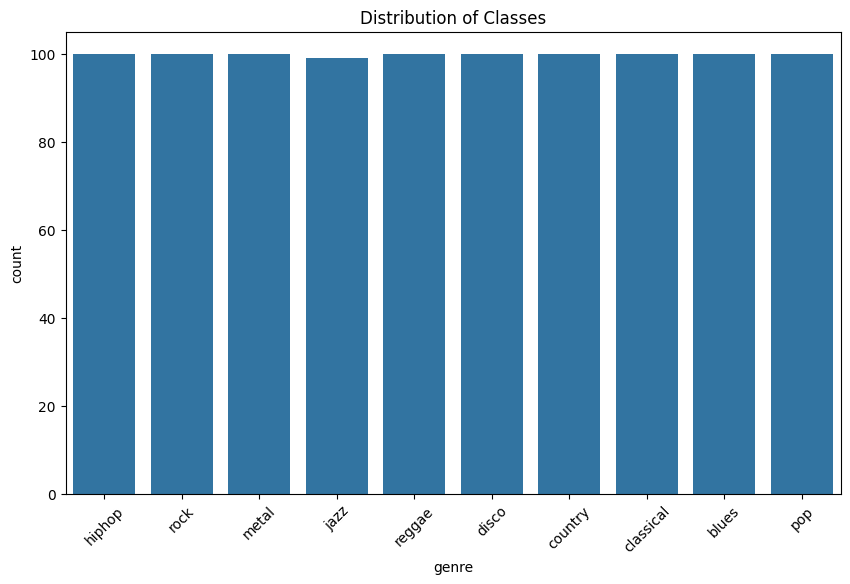

In [ ]:

music_dataset = []
genre_target = []

# Gather data
for root, dirs, files in os.walk(MUSIC):
    for name in files:
        filename = os.path.join(root, name)
        if filename != '/content/Data/genres_original/jazz/jazz.00054.wav':

          genre_target.append(filename.split("/")[4])
          music_dataset.append(filename)


# Convert to DataFrame
df = pd.DataFrame({
    'file_path': music_dataset,
    'genre': genre_target
})

# Check if DataFrame is populated
print(f"DataFrame shape: {df.shape}")
print(df.head())

# Plot the distribution of classes
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='genre')
plt.title('Distribution of Classes')
plt.xticks(rotation=45)
plt.show()


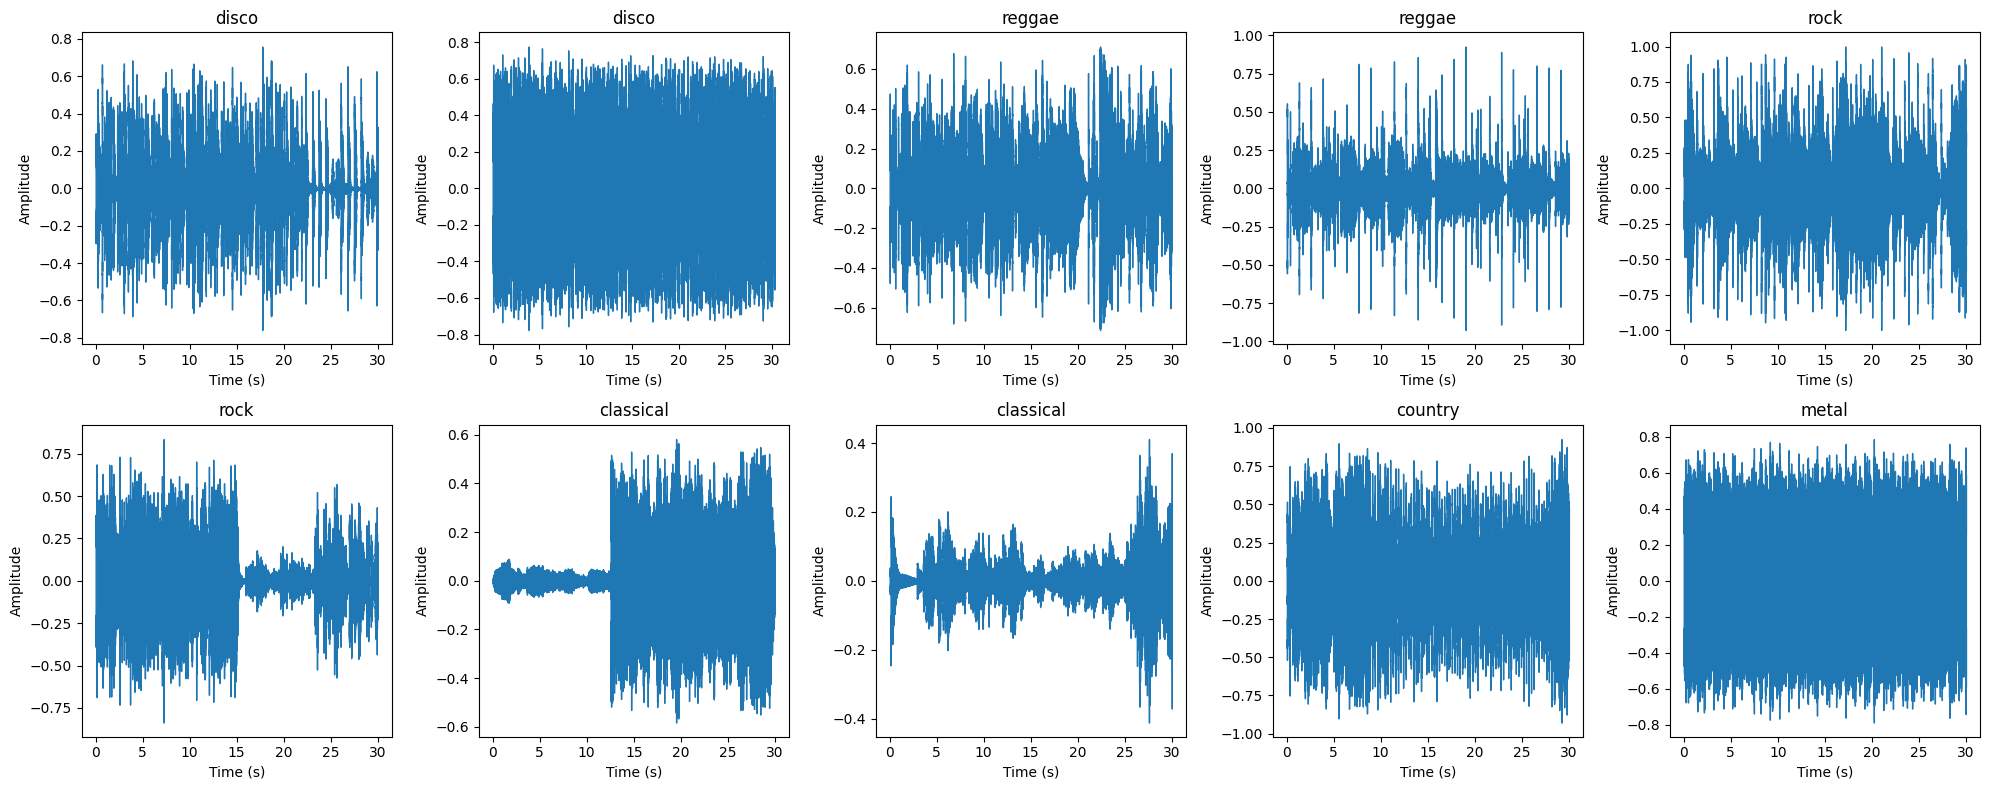

In [ ]:
# Step 2: Visualize Audio Waveforms
def plot_waveform(file_path, ax):
    y, sr = librosa.load(file_path)
    librosa.display.waveshow(y, sr=sr, ax=ax)
    ax.set(title='Waveform', xlabel='Time (s)', ylabel='Amplitude')

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
for ax, (file_path, genre) in zip(axes, df.sample(10).values):
    plot_waveform(file_path, ax)
    ax.set(title=f'{genre}')

plt.tight_layout()
plt.show()

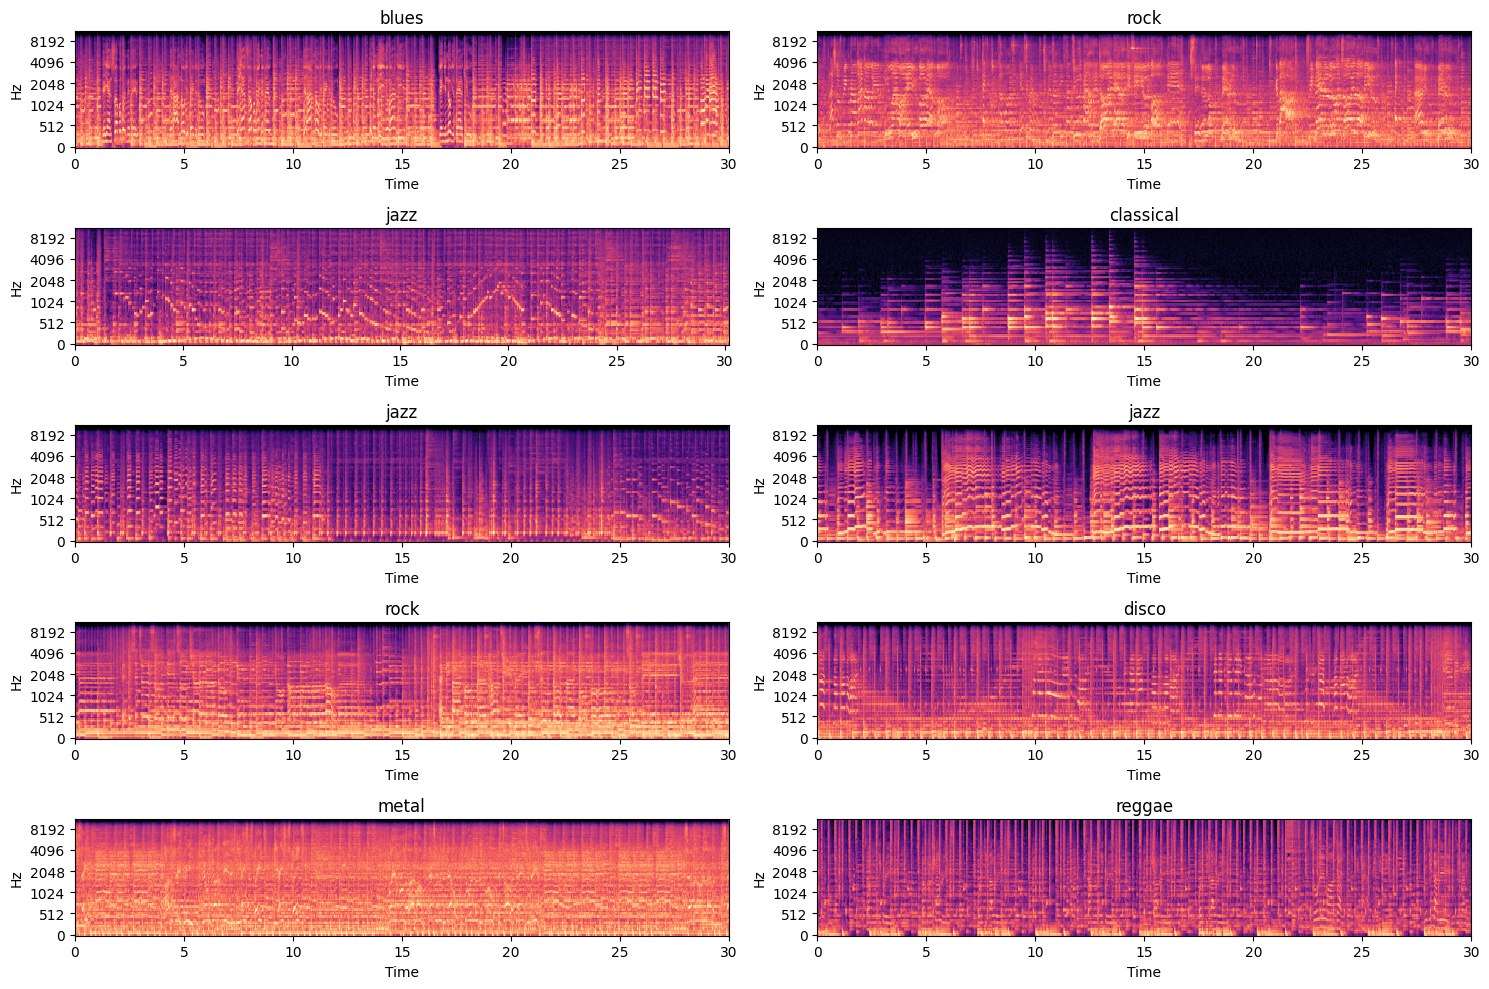

In [ ]:
# Function to plot mel spectrogram
def plot_melspectrogram(file_path, ax):
    y, sr = librosa.load(file_path)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=96)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    img = librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=ax)
    return img

# Plotting mel spectrograms of random samples
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for ax, (file_path, genre) in zip(axes, df.sample(10).values):
    plot_melspectrogram(file_path, ax)
    ax.set(title=f'{genre}')

plt.tight_layout()
plt.show()

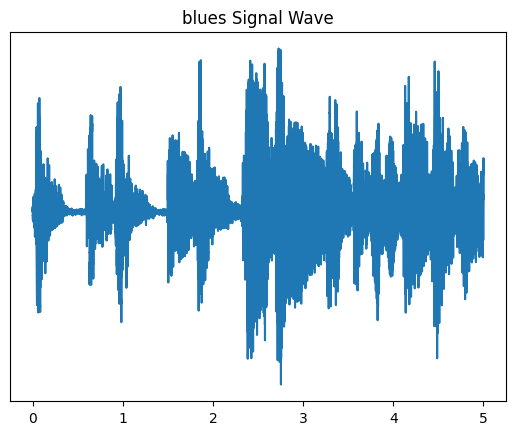

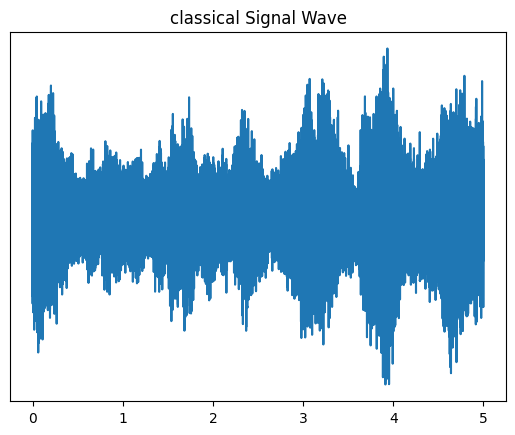

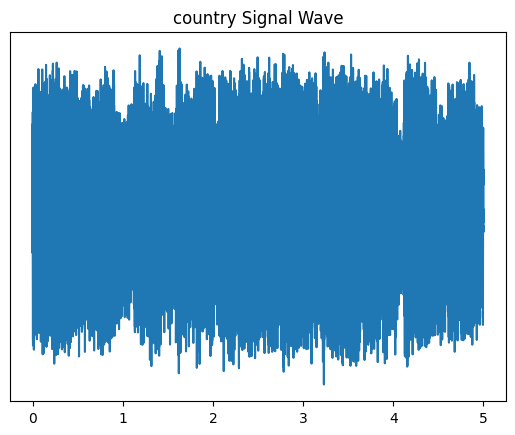

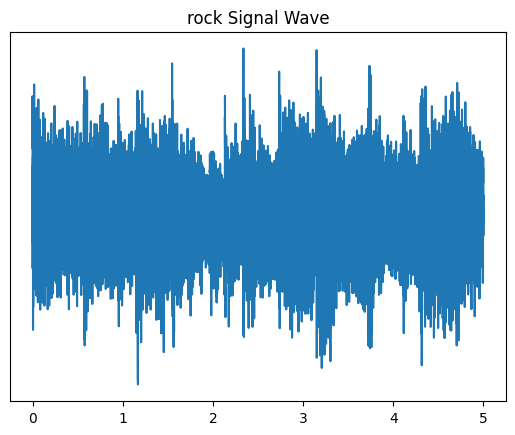

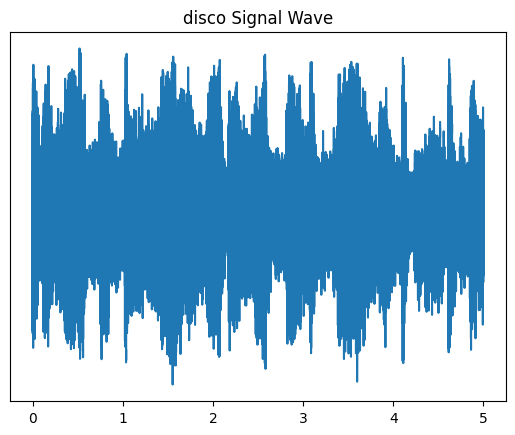

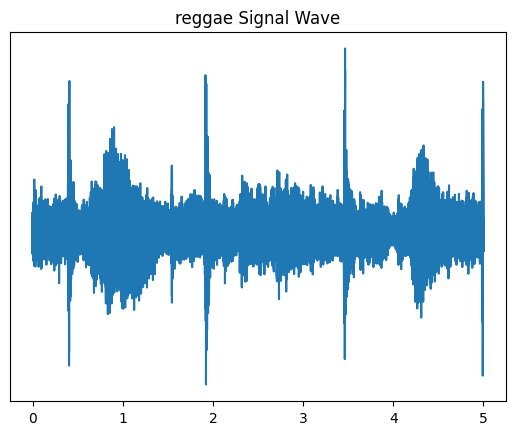

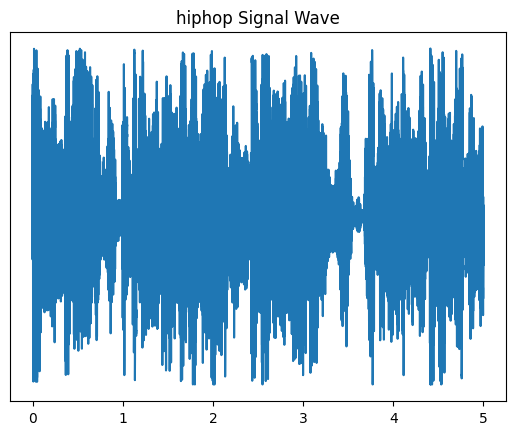

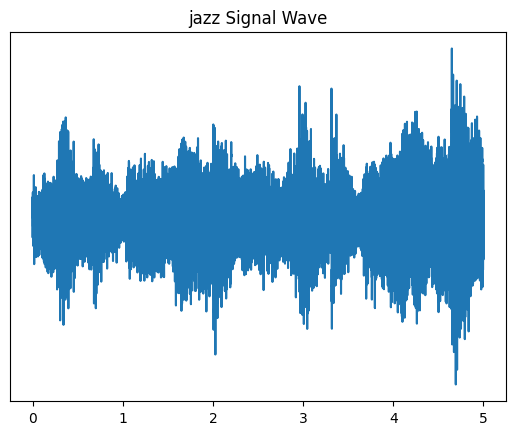

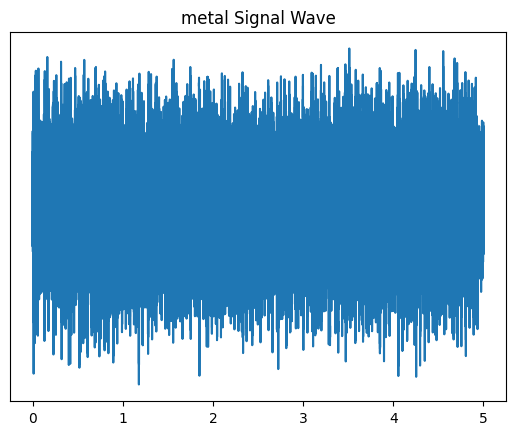

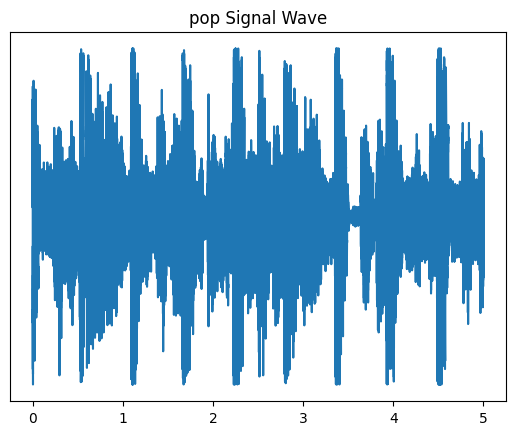

In [ ]:

# Path to the dataset
data_path = '/content/Data/genres_original'

# List of genres
genres = 'blues classical country rock disco reggae hiphop jazz metal pop'.split()

for i, genre in enumerate(genres):
    file_path = os.path.join(data_path, genre, f'{genre}.00001.wav')
    y, sr = librosa.load(file_path, duration=5.0, sr=None)
    time = np.linspace(0, len(y) / sr, num=len(y))

    plt.figure(i + 1)
    plt.title(genre + " Signal Wave")
    plt.yticks(ticks=[])
    plt.plot(time, y)
    plt.savefig(fname=genre + '_time_domain.png', dpi=200)
    plt.show()


In [ ]:
y, sfr = librosa.load('/content/Data/genres_original/blues/blues.00000.wav')

In [ ]:
y.shape,  sfr

((661794,), 22050)

In [ ]:
# Check if CUDA (GPU) is available
cuda_available = torch.cuda.is_available()

if cuda_available:
    print(f"CUDA is available! Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Switch to CPU mode if needed.")

CUDA is available! Using GPU: NVIDIA L4


In [ ]:
y, sfr = librosa.load('/content/Data/genres_original/blues/blues.00000.wav')

In [ ]:
y.shape,  sfr

((661794,), 22050)

# **Base Models**

In [ ]:
mel_spectrograms = []
labels = []

for idx, audio_file in enumerate(music_dataset):
    audio_data, sample_rate = librosa.load(audio_file)
    divided_audio = np.split(audio_data[:660000], 10)
    for segment in divided_audio:
        mel_spec = librosa.feature.melspectrogram(y=segment, sr=sample_rate, n_mels=128, hop_length=256, n_fft=1024)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spectrograms.append(mel_spec_db)
        labels.append(genre_target[idx])

genre_mapping = {'pop': 1, 'classical': 2, 'reggae': 3, 'disco': 4, 'jazz': 5, 'metal': 6, 'country': 7, 'blues': 8, 'hiphop': 9, 'rock': 0}
genre_ids = [genre_mapping[genre] for genre in labels]

X_train, X_temp, y_train, y_temp = train_test_split(mel_spectrograms, genre_ids, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



In [ ]:

# Convert lists to NumPy arrays
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_val_np = np.array(X_val)
y_val_np = np.array(y_val)
X_test_np = np.array(X_test)
y_test_np = np.array(y_test)

# Create feature and target tensors for train, validation, and test sets
torch_X_train = torch.unsqueeze(torch.tensor(X_train_np, dtype=torch.float32, device='cuda'), 1)
torch_y_train = torch.tensor(y_train_np, dtype=torch.int64, device='cuda')
torch_X_val = torch.unsqueeze(torch.tensor(X_val_np, dtype=torch.float32, device='cuda'), 1)
torch_y_val = torch.tensor(y_val_np, dtype=torch.int64, device='cuda')
torch_X_test = torch.unsqueeze(torch.tensor(X_test_np, dtype=torch.float32, device='cuda'), 1)
torch_y_test = torch.tensor(y_test_np, dtype=torch.int64, device='cuda')

# Pytorch train, validation, and test sets
train_dataset = TensorDataset(torch_X_train, torch_y_train)
val_dataset = TensorDataset(torch_X_val, torch_y_val)
test_dataset = TensorDataset(torch_X_test, torch_y_test)



In [ ]:
batch_size = 120
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## **Model-1**

In [ ]:
class AudioClassifierWithExtraConv(nn.Module):
    def __init__(self, num_classes=10):
        super(AudioClassifierWithExtraConv, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # This will adapt to any input size
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=256, out_features=num_classes)
        )

        self.apply(self._initialize_weights)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        output = self.fc_layers(x)
        return output

    def _initialize_weights(self, layer):
        if isinstance(layer, nn.Conv2d):
            nn.init.kaiming_uniform_(layer.weight)
        elif isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)


# Create model instance
model1 = AudioClassifierWithExtraConv()
model1.cuda()

# Define loss function and optimizer
criterion1 = nn.CrossEntropyLoss()
learning_rate1 = 0.001
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate1)

# Print model architecture
print(model1)


AudioClassifierWithExtraConv(
  (conv_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, 

Epoch: 0 [0/5994 (0%)]	Train Loss: 2.652131	Train Accuracy: 6.667%
Epoch: 0 Validation Loss: 1.388705	Validation Accuracy: 47.297%
New best model saved with validation accuracy: 47.297%
Epoch: 1 [0/5994 (0%)]	Train Loss: 1.538126	Train Accuracy: 38.333%
Epoch: 1 Validation Loss: 1.408912	Validation Accuracy: 45.946%
Epoch: 2 [0/5994 (0%)]	Train Loss: 1.384390	Train Accuracy: 56.667%
Epoch: 2 Validation Loss: 1.355974	Validation Accuracy: 54.555%
New best model saved with validation accuracy: 54.555%
Epoch: 3 [0/5994 (0%)]	Train Loss: 1.157355	Train Accuracy: 60.833%
Epoch: 3 Validation Loss: 1.111639	Validation Accuracy: 59.610%
New best model saved with validation accuracy: 59.610%
Epoch: 4 [0/5994 (0%)]	Train Loss: 0.955972	Train Accuracy: 62.500%
Epoch: 4 Validation Loss: 2.253041	Validation Accuracy: 49.550%
Epoch: 5 [0/5994 (0%)]	Train Loss: 0.746601	Train Accuracy: 78.333%
Epoch: 5 Validation Loss: 0.819968	Validation Accuracy: 72.272%
New best model saved with validation accurac

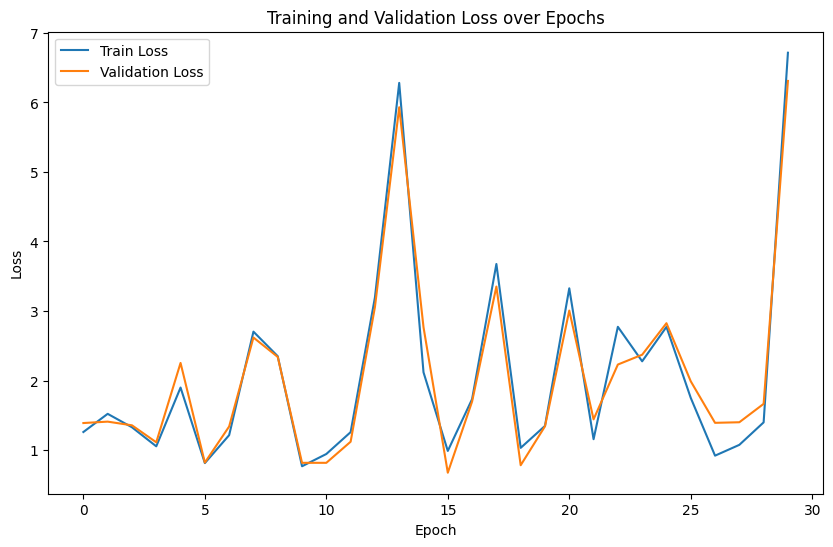

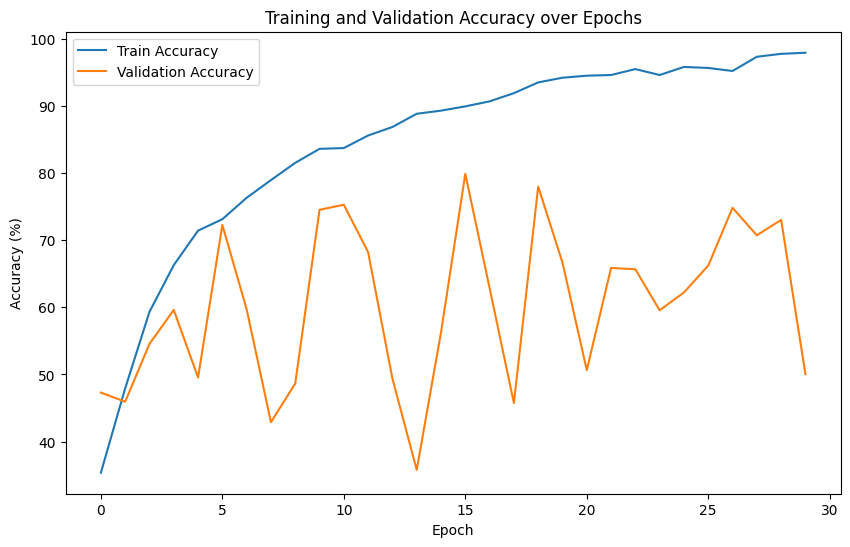

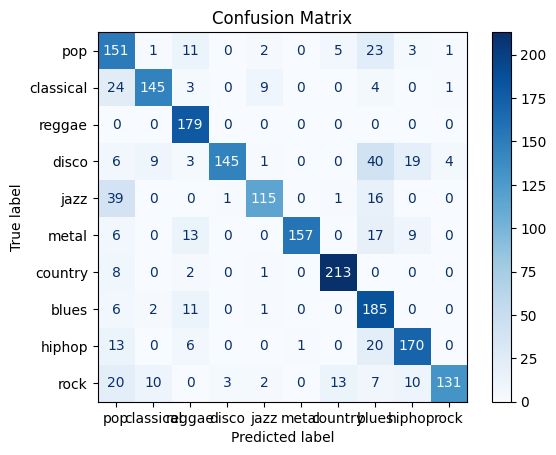

In [ ]:


# Lists to store training, validation, and testing metrics
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
test_loss_history = []
test_acc_history = []

# Define your model, optimizer, and other necessary components
model1 = AudioClassifierWithExtraConv()  # Assuming AudioClassifierWithExtraConv is your model class
model1.cuda()

error = nn.CrossEntropyLoss()  # Define your loss function
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)  # Define your optimizer

# Training and testing loop
EPOCHS = 30
best_val_acc = 0
best_model_path = 'best_model.pth'

for epoch in range(EPOCHS):
    # Training
    model1.train()
    correct_train = 0
    total_train = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = Variable(X_batch).float().cuda()
        var_y_batch = Variable(y_batch).cuda()
        optimizer1.zero_grad()

        # Forward pass
        output = model1(var_X_batch)

        # Calculate loss
        loss = error(output, var_y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer1.step()

        # Total correct predictions
        predicted = torch.max(output.data, 1)[1]
        correct_train += (predicted == var_y_batch).sum().item()
        total_train += var_y_batch.size(0)

        # Print training statistics
        if batch_idx % 50 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}\tTrain Accuracy: {:.3f}%'.format(
                epoch, batch_idx * len(X_batch), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                float(correct_train) / float(total_train) * 100))

    # Validation
    model1.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            var_X_val = Variable(X_val).float().cuda()
            var_y_val = Variable(y_val).cuda()

            # Forward pass
            output = model1(var_X_val)

            # Calculate loss
            loss = error(output, var_y_val)
            val_loss += loss.item()

            # Total correct predictions
            predicted = torch.max(output.data, 1)[1]
            correct_val += (predicted == var_y_val).sum().item()
            total_val += var_y_val.size(0)

    # Average validation loss
    val_loss /= len(val_loader)
    val_acc = float(correct_val) / float(total_val) * 100.0
    print('Epoch: {} Validation Loss: {:.6f}\tValidation Accuracy: {:.3f}%'.format(epoch, val_loss, val_acc))

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model1.state_dict(), best_model_path)
        print(f"New best model saved with validation accuracy: {best_val_acc:.3f}%")

    # Store metrics for plotting
    train_loss_history.append(loss.item())
    train_acc_history.append(float(correct_train) / float(total_train) * 100.0)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

# Testing
model1.load_state_dict(torch.load(best_model_path))  # Load the best model
model1.eval()
correct_test = 0
total_test = 0
test_loss = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for X_test, y_test in test_loader:
        var_X_test = Variable(X_test).float().cuda()
        var_y_test = Variable(y_test).cuda()

        # Forward pass
        output = model1(var_X_test)

        # Calculate loss
        loss = error(output, var_y_test)
        test_loss += loss.item()

        # Total correct predictions
        predicted = torch.max(output.data, 1)[1]
        correct_test += (predicted == var_y_test).sum().item()
        total_test += var_y_test.size(0)

        # Collect predictions and labels for confusion matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(var_y_test.cpu().numpy())

# Average test loss
test_loss /= len(test_loader)
test_acc = float(correct_test) / float(total_test) * 100.0
print('Test Loss: {:.6f}\tTest Accuracy: {:.3f}%'.format(test_loss, test_acc))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_mapping.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


## **Model 2**

In [ ]:

class AudioClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(AudioClassifier, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=512 * 1 * 2, out_features=1024),  # Changed from 512 * 1 * 4 to 512 * 1 * 2
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=1024, out_features=256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=256, out_features=num_classes)
        )

        self.apply(self._initialize_weights)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        output = self.fc_layers(x)
        return output

    def _initialize_weights(self, layer):
        if isinstance(layer, nn.Conv2d):
            nn.init.kaiming_uniform_(layer.weight)
        elif isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)

In [ ]:
# Create model instance
model = AudioClassifier()
model.cuda()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Print model architecture
print(model)


AudioClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_st

Epoch: 0 [0/7992 (0%)]	Train Loss: 1.782867	Train Accuracy: 32.500%
Epoch: 0 [6000/7992 (75%)]	Train Loss: 1.502676	Train Accuracy: 42.712%
Epoch: 0 Test Loss: 1.430366	Test Accuracy: 51.502%
Epoch: 1 [0/7992 (0%)]	Train Loss: 1.194321	Train Accuracy: 54.167%
Epoch: 1 [6000/7992 (75%)]	Train Loss: 1.171621	Train Accuracy: 52.320%
Epoch: 1 Test Loss: 1.228776	Test Accuracy: 53.403%
Epoch: 2 [0/7992 (0%)]	Train Loss: 1.113050	Train Accuracy: 60.833%
Epoch: 2 [6000/7992 (75%)]	Train Loss: 1.146281	Train Accuracy: 61.814%
Epoch: 2 Test Loss: 1.168479	Test Accuracy: 60.911%
Epoch: 3 [0/7992 (0%)]	Train Loss: 0.848235	Train Accuracy: 71.667%
Epoch: 3 [6000/7992 (75%)]	Train Loss: 0.769205	Train Accuracy: 67.206%
Epoch: 3 Test Loss: 1.054962	Test Accuracy: 67.317%
Epoch: 4 [0/7992 (0%)]	Train Loss: 1.014996	Train Accuracy: 65.000%
Epoch: 4 [6000/7992 (75%)]	Train Loss: 0.809341	Train Accuracy: 71.977%
Epoch: 4 Test Loss: 1.118771	Test Accuracy: 68.218%
Epoch: 5 [0/7992 (0%)]	Train Loss: 0.697

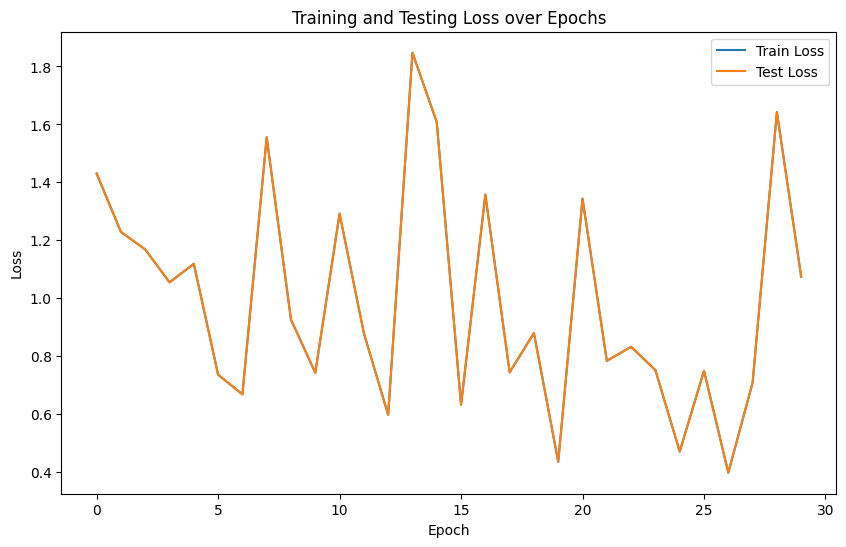

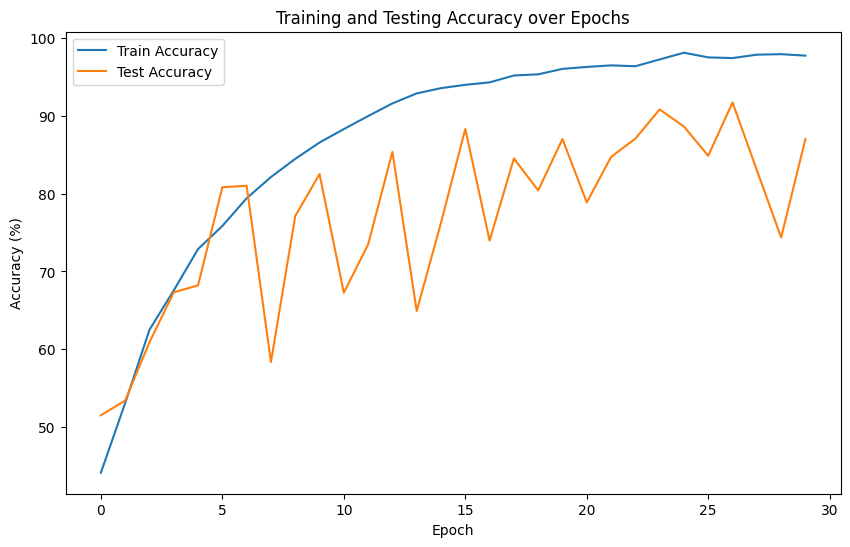

In [ ]:


# Lists to store training and testing metrics
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

# Training and testing loop
EPOCHS = 30
for epoch in range(EPOCHS):
    # Training
    model.train()
    correct_train = 0
    total_train = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = Variable(X_batch).float().cuda()
        var_y_batch = Variable(y_batch).cuda()
        optimizer.zero_grad()

        # Forward pass
        output = model(var_X_batch)

        # Calculate loss
        loss = criterion(output, var_y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Total correct predictions
        predicted = torch.max(output.data, 1)[1]
        correct_train += (predicted == var_y_batch).sum().item()
        total_train += var_y_batch.size(0)

        # Print training statistics
        if batch_idx % 50 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}\tTrain Accuracy: {:.3f}%'.format(
                epoch, batch_idx * len(X_batch), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                float(correct_train) / float(total_train) * 100))

    # Testing
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for X_test, y_test in test_loader:
            var_X_test = Variable(X_test).float().cuda()
            var_y_test = Variable(y_test).cuda()

            # Forward pass
            output = model(var_X_test)

            # Calculate loss
            loss = criterion(output, var_y_test)

            # Total correct predictions
            predicted = torch.max(output.data, 1)[1]
            correct_test += (predicted == var_y_test).sum().item()
            total_test += var_y_test.size(0)

    # Print testing statistics
    test_loss = loss.item()
    test_acc = float(correct_test) / float(total_test) * 100.0
    print('Epoch: {} Test Loss: {:.6f}\tTest Accuracy: {:.3f}%'.format(epoch, test_loss, test_acc))

    # Store metrics for plotting
    train_loss_history.append(loss.item())
    train_acc_history.append(float(correct_train) / float(total_train) * 100.0)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy over Epochs')
plt.legend()
plt.show()


# **LSTM Model**

In [ ]:


class AudioClassifierLSTM(nn.Module):
    def __init__(self, num_classes=10):
        super(AudioClassifierLSTM, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4)
        )

        self.lstm = nn.LSTM(input_size=512, hidden_size=256, num_layers=1, batch_first=True)

        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=256, out_features=256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=256, out_features=num_classes)
        )

        self.apply(self._initialize_weights)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.squeeze(2)  # Remove the dimension of size 1
        x = x.permute(0, 2, 1)  # Reshape to (batch_size, seq_len, features)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Take the output of the last time step
        output = self.fc_layers(x)
        return output

    def _initialize_weights(self, layer):
        if isinstance(layer, nn.Conv2d):
            nn.init.kaiming_uniform_(layer.weight)
        elif isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)

Epoch: 0 [0/7992 (0%)]	Train Loss: 2.400903	Train Accuracy: 7.500%
Epoch: 0 [6000/7992 (75%)]	Train Loss: 1.465189	Train Accuracy: 42.206%
Epoch: 0 Test Loss: 1.275726	Test Accuracy: 62.012%
Epoch: 1 [0/7992 (0%)]	Train Loss: 1.128045	Train Accuracy: 61.667%
Epoch: 1 [6000/7992 (75%)]	Train Loss: 0.927394	Train Accuracy: 65.605%
Epoch: 1 Test Loss: 1.082945	Test Accuracy: 67.918%
Epoch: 2 [0/7992 (0%)]	Train Loss: 0.814142	Train Accuracy: 72.500%
Epoch: 2 [6000/7992 (75%)]	Train Loss: 0.726146	Train Accuracy: 74.902%
Epoch: 2 Test Loss: 0.868705	Test Accuracy: 72.723%
Epoch: 3 [0/7992 (0%)]	Train Loss: 0.499365	Train Accuracy: 82.500%
Epoch: 3 [6000/7992 (75%)]	Train Loss: 0.446985	Train Accuracy: 80.850%
Epoch: 3 Test Loss: 1.363206	Test Accuracy: 65.165%
Epoch: 4 [0/7992 (0%)]	Train Loss: 0.624820	Train Accuracy: 75.833%
Epoch: 4 [6000/7992 (75%)]	Train Loss: 0.536417	Train Accuracy: 84.510%
Epoch: 4 Test Loss: 1.001709	Test Accuracy: 78.128%
Epoch: 5 [0/7992 (0%)]	Train Loss: 0.3021

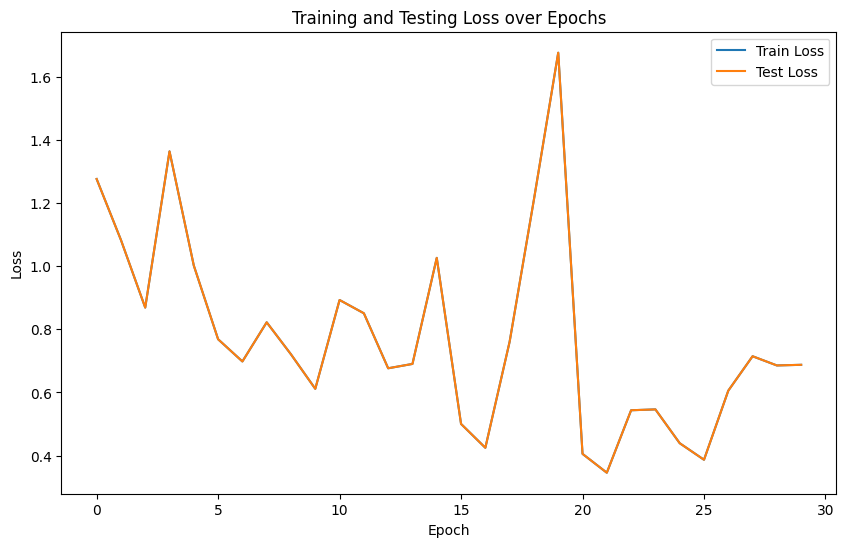

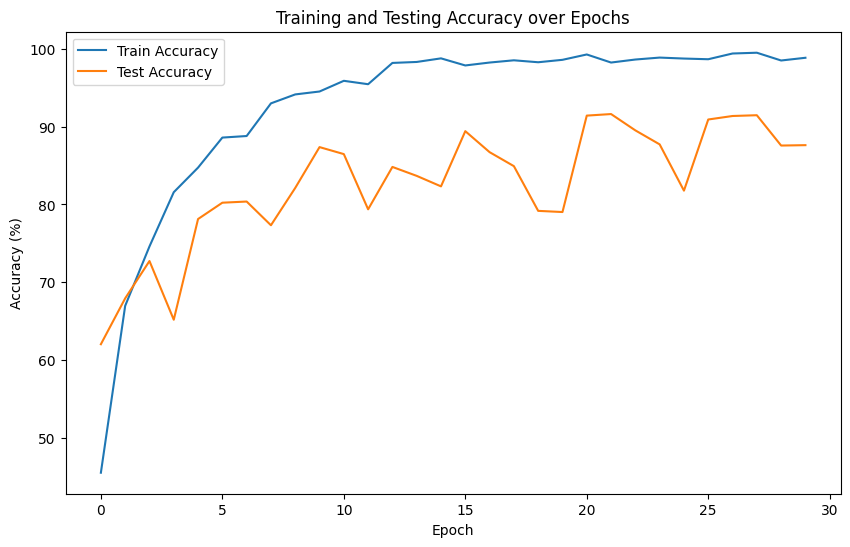

In [ ]:


# Lists to store training and testing metrics
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

# Create model instance
model_lstm = AudioClassifierLSTM()
model_lstm.cuda()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=0.001)

# Early stopping parameters
patience = 5
best_accuracy = 0
epochs_no_improve = 0
best_model_path = 'best_model_lstm.pth'

# Training and testing loop
EPOCHS = 30
for epoch in range(EPOCHS):
    # Training
    model_lstm.train()
    correct_train = 0
    total_train = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = Variable(X_batch).float().cuda()
        var_y_batch = Variable(y_batch).cuda()
        optimizer_lstm.zero_grad()

        # Forward pass
        output = model_lstm(var_X_batch)

        # Calculate loss
        loss = criterion(output, var_y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer_lstm.step()

        # Total correct predictions
        predicted = torch.max(output.data, 1)[1]
        correct_train += (predicted == var_y_batch).sum().item()
        total_train += var_y_batch.size(0)

        # Print training statistics
        if batch_idx % 50 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}\tTrain Accuracy: {:.3f}%'.format(
                epoch, batch_idx * len(X_batch), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                float(correct_train) / float(total_train) * 100))

    # Testing
    model_lstm.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0
    with torch.no_grad():
        for X_test, y_test in test_loader:
            var_X_test = Variable(X_test).float().cuda()
            var_y_test = Variable(y_test).cuda()

            # Forward pass
            output = model_lstm(var_X_test)

            # Calculate loss
            loss = criterion(output, var_y_test)
            test_loss += loss.item()

            # Total correct predictions
            predicted = torch.max(output.data, 1)[1]
            correct_test += (predicted == var_y_test).sum().item()
            total_test += var_y_test.size(0)

    # Print testing statistics
    test_loss /= len(test_loader)
    test_acc = float(correct_test) / float(total_test) * 100.0
    print('Epoch: {} Test Loss: {:.6f}\tTest Accuracy: {:.3f}%'.format(epoch, test_loss, test_acc))

    # Store metrics for plotting
    train_loss_history.append(loss.item())
    train_acc_history.append(float(correct_train) / float(total_train) * 100.0)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)

    # Check if this is the best model
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        epochs_no_improve = 0
        torch.save(model_lstm.state_dict(), best_model_path)
        print(f"New best model saved with accuracy: {best_accuracy:.3f}%")
    else:
        epochs_no_improve += 1

    # Check early stopping condition
    if epochs_no_improve == patience:
        print(f"Early stopping triggered. No improvement for {patience} epochs.")
        break

print(f"Training complete. Best accuracy: {best_accuracy:.3f}%")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy over Epochs')
plt.legend()
plt.show()

# **GRU model**

In [ ]:
class AudioClassifierGRU(nn.Module):
    def __init__(self, num_classes=10):
        super(AudioClassifierGRU, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4)
        )

        self.gru = nn.GRU(input_size=512, hidden_size=256, num_layers=1, batch_first=True)

        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=256, out_features=256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=256, out_features=num_classes)
        )

        self.apply(self._initialize_weights)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.squeeze(2)  # Remove the dimension of size 1
        x = x.permute(0, 2, 1)  # Reshape to (batch_size, seq_len, features)
        x, _ = self.gru(x)
        x = x[:, -1, :]  # Take the output of the last time step
        output = self.fc_layers(x)
        return output

    def _initialize_weights(self, layer):
        if isinstance(layer, nn.Conv2d):
            nn.init.kaiming_uniform_(layer.weight)
        elif isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)

# Create model instance
model_gru = AudioClassifierGRU()
model_gru.cuda()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_gru = optim.Adam(model_gru.parameters(), lr=0.001)

# Print model architecture
print(model_gru)



AudioClassifierGRU(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running

Epoch: 0 [0/7992 (0%)]	Train Loss: 2.361748	Train Accuracy: 10.000%
Epoch: 0 [6000/7992 (75%)]	Train Loss: 1.234501	Train Accuracy: 43.137%
Epoch: 0 Test Loss: 1.073996	Test Accuracy: 61.311%
New best model saved with accuracy: 61.311%
Epoch: 1 [0/7992 (0%)]	Train Loss: 1.116839	Train Accuracy: 62.500%
Epoch: 1 [6000/7992 (75%)]	Train Loss: 0.940449	Train Accuracy: 64.265%
Epoch: 1 Test Loss: 0.790211	Test Accuracy: 72.122%
New best model saved with accuracy: 72.122%
Epoch: 2 [0/7992 (0%)]	Train Loss: 0.836356	Train Accuracy: 75.000%
Epoch: 2 [6000/7992 (75%)]	Train Loss: 0.932070	Train Accuracy: 72.582%
Epoch: 2 Test Loss: 0.877689	Test Accuracy: 68.018%
Epoch: 3 [0/7992 (0%)]	Train Loss: 0.790820	Train Accuracy: 70.000%
Epoch: 3 [6000/7992 (75%)]	Train Loss: 0.420635	Train Accuracy: 80.180%
Epoch: 3 Test Loss: 0.939299	Test Accuracy: 65.716%
Epoch: 4 [0/7992 (0%)]	Train Loss: 0.604282	Train Accuracy: 76.667%
Epoch: 4 [6000/7992 (75%)]	Train Loss: 0.412380	Train Accuracy: 81.944%
Epoc

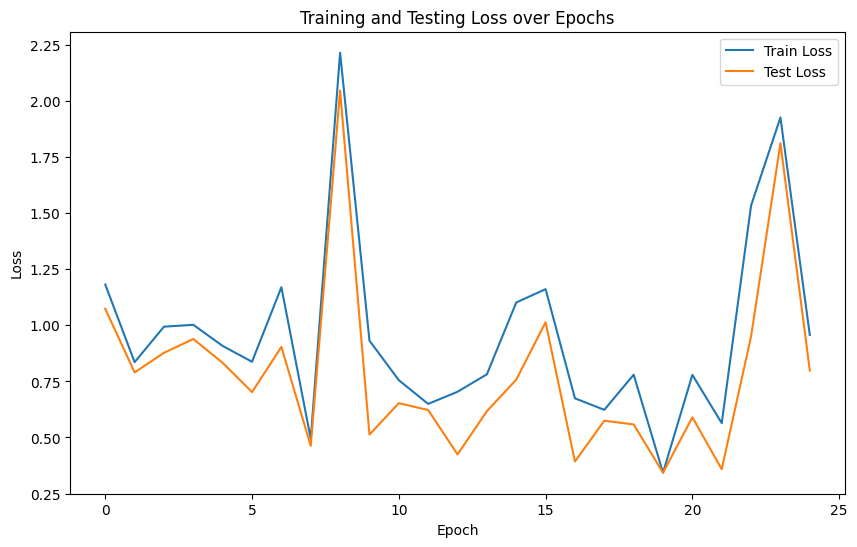

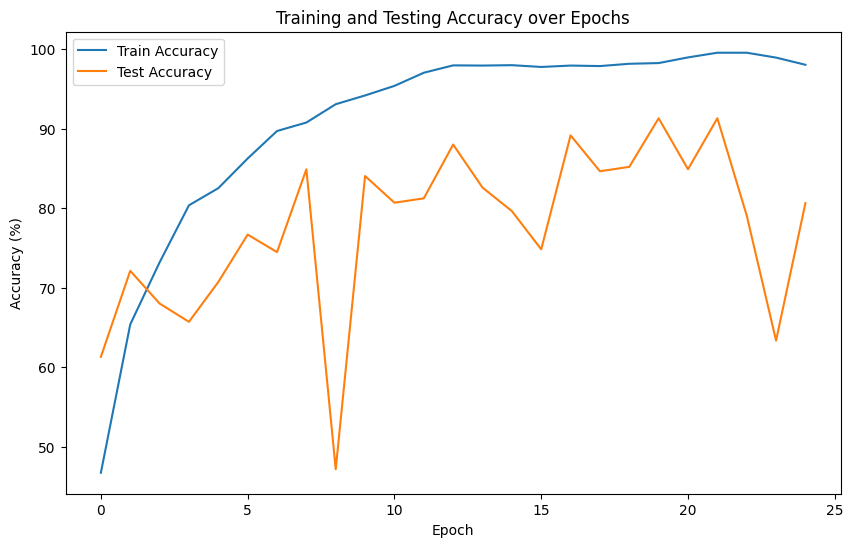

In [ ]:
# Lists to store training and testing metrics
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

# Create model instance
model_lstm = AudioClassifierLSTM()
model_lstm.cuda()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=0.001)

# Variables to keep track of best accuracy and early stopping
best_accuracy = 0.0
best_model_path = 'best_model_lstm.pth'
patience = 5
epochs_no_improve = 0

# Training and testing loop
EPOCHS = 30
for epoch in range(EPOCHS):
    # Training
    model_lstm.train()
    correct_train = 0
    total_train = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = Variable(X_batch).float().cuda()
        var_y_batch = Variable(y_batch).cuda()
        optimizer_lstm.zero_grad()

        # Forward pass
        output = model_lstm(var_X_batch)

        # Calculate loss
        loss = criterion(output, var_y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer_lstm.step()

        # Total correct predictions
        predicted = torch.max(output.data, 1)[1]
        correct_train += (predicted == var_y_batch).sum().item()
        total_train += var_y_batch.size(0)

        # Print training statistics
        if batch_idx % 50 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}\tTrain Accuracy: {:.3f}%'.format(
                epoch, batch_idx * len(X_batch), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                float(correct_train) / float(total_train) * 100))

    # Testing
    model_lstm.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0
    with torch.no_grad():
        for X_test, y_test in test_loader:
            var_X_test = Variable(X_test).float().cuda()
            var_y_test = Variable(y_test).cuda()

            # Forward pass
            output = model_lstm(var_X_test)

            # Calculate loss
            loss = criterion(output, var_y_test)
            test_loss += loss.item()

            # Total correct predictions
            predicted = torch.max(output.data, 1)[1]
            correct_test += (predicted == var_y_test).sum().item()
            total_test += var_y_test.size(0)

    # Calculate average test loss and accuracy
    test_loss /= len(test_loader)
    test_acc = float(correct_test) / float(total_test) * 100.0

    # Print testing statistics
    print('Epoch: {} Test Loss: {:.6f}\tTest Accuracy: {:.3f}%'.format(epoch, test_loss, test_acc))

    # Store metrics for plotting
    train_loss_history.append(loss.item())
    train_acc_history.append(float(correct_train) / float(total_train) * 100.0)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)

    # Check if the current model is the best
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        torch.save(model_lstm.state_dict(), best_model_path)
        print(f"New best model saved with accuracy: {best_accuracy:.3f}%")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Check early stopping condition
    if epochs_no_improve == patience:
        print(f"Early stopping triggered. No improvement for {patience} epochs.")
        break

print(f"Training complete. Best accuracy: {best_accuracy:.3f}%")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy over Epochs')
plt.legend()
plt.show()